# Play around with GAN model using MNIST dataset

In [70]:
import keras
from keras.models import Sequential,Model
from keras.datasets import mnist
import matplotlib.pyplot as plt
from keras.layers import Dense,LeakyReLU,Conv2D,Flatten,Input,Reshape,Dropout
from keras import optimizers,initializers
import numpy as np

## Load the MNIST dataset

In [71]:
# Load the MNIST dataset
(X_train,y_train),(x_test,y_test) = mnist.load_data()

## Print basic information about the dataset

The shape of the picture is(28, 28)
Number of pictures in the train dataset(60000, 28, 28)


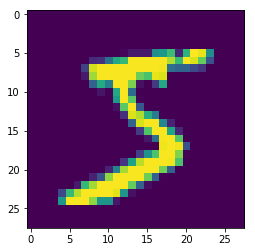

In [72]:
# Get basic information about the data
plt.imshow(X_train[0])
print("The shape of the picture is"+ str(X_train[0].shape))
print("Number of pictures in the train dataset"+str(X_train.shape))

## Normalize the image from (0,255) into range(-1,1) 

In [73]:
Max = np.max(X_train[0])
Min = np.min(X_train[0])
Mid = (Max+Min)/2
print("The maximum of the array "+ str(Max))
print("The minimum of the array "+ str(Min))
# Normalization the image into range(-1,1)
X_train = (X_train.astype(np.float32) - Mid)/Mid

The maximum of the array 255
The minimum of the array 0


## Define Generator 
#### I got this Adam parameter setting at a guy's github
#### I checked some tips, for general, the parameter will set as alpha=0.001, beta1=0.9, beta2=0.999 and epsilon=10−8
#### adam = optimizers.Adam(lr=0.0002, beta_1=0.5,beta_2=0.999,epsilon=None) 
#### Using one dense layer followed by three Conv2D layer

In [74]:
# Define Generator 
# I got this Adam parameter setting at a guys github
# I checked some tips, for general, the parameter will set as alpha=0.001, beta1=0.9, beta2=0.999 and epsilon=10−8
adam = optimizers.Adam(lr=0.0002, beta_1=0.5,beta_2=0.999,epsilon=None) 
# Define Generator
def build_generator(input_dim):
    #Using one dense layer followed by three Conv2D layer
    generator = Sequential()
    generator.add(Dense(784,input_dim=input_dim))
    generator.add(LeakyReLU(0.2))
    generator.add(Reshape((28,28,1)))
    generator.add(Conv2D(8,(3,3),padding='same'))
    generator.add(LeakyReLU(0.2))
    generator.add(Conv2D(16,(3,3),padding='same'))
    generator.add(LeakyReLU(0.2))
    generator.add(Conv2D(32,(3,3),padding='same'))
    generator.add(LeakyReLU(0.2))
    generator.add(Flatten())
    generator.add(Dense(784,activation='tanh'))
    generator.compile(optimizer =adam,loss='binary_crossentropy')
    return generator

## Define Discrimator
#### Using five dense layers with leakyReLU and Drop out 

In [75]:
# Define Discriminator
def build_discriminator():
    # Using five dense layers with leakyReLU and Drop out 
    discriminator = Sequential()
    discriminator.add(Dense(1024,input_dim=784))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.5))
    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.5))
    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.5))
    discriminator.add(Dense(128))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.5))
    discriminator.add(Dense(1,activation='sigmoid'))
    discriminator.compile(optimizer =adam,loss='binary_crossentropy')
    return discriminator

## Define GAN

In [76]:
# Define GAN Model
def build_gan(input_dim):
    generator = build_generator(input_dim)
    discriminator = build_discriminator()
    discriminator.trainable = False
    inputs = Input(shape=(input_dim, ))
    hidden = generator(inputs)
    output = discriminator(hidden)
    gan = Model(inputs, output)
    gan.compile(loss='binary_crossentropy', optimizer=adam)
    return generator,discriminator,gan

## Define Training Process

In [77]:
# Training
def train(epochs=30, BATCH_SIZE=128,input_dim=100):
    
    # preprocessing
    global X_train
    X_train = X_train.reshape(60000, 784)
    
    # Information 
    batchCount = int(X_train.shape[0] / BATCH_SIZE)
    print('Epochs:', epochs)
    print('Batch size:', BATCH_SIZE)
    print('Batches per epoch:', batchCount)
    
    G_loss = []
    D_loss = []
    
    generator,discriminator,gan=build_gan(input_dim)
    
    for i in range(epochs):
        
        print("Begin the {} epochs!".format(i))
        
        for _ in range(batchCount):  
            # Create a batch by drawing random index numbers from the training set
            image_batch = X_train[np.random.randint(0, X_train.shape[0], size=BATCH_SIZE)]
            # Create noise vectors for the generator
            noise = np.random.normal(0, 1, size=(BATCH_SIZE, 100))

            # Generate the images from the noise
            generated_images = generator.predict(noise)
            X = np.concatenate((image_batch, generated_images))
            # Create labels
            y = np.zeros(2*BATCH_SIZE)
            y[:BATCH_SIZE] = 1

            # Train discriminator on generated images
            discriminator.trainable = True
            d_loss = discriminator.train_on_batch(X, y)

            # Train generator
            noise = np.random.normal(0, 1, size=(BATCH_SIZE, 100))
            y2 = np.ones(BATCH_SIZE)
            discriminator.trainable = False
            g_loss = gan.train_on_batch(noise, y2)
            
        print("D_loss= "+str(d_loss)+","+"G_loss ="+str(g_loss))
        D_loss.append(d_loss)
        G_loss.append(g_loss)
        
    print("Training Finished!")
    return D_loss,G_loss,generator

## Train the model here

In [78]:
# Train the model and return D_loss, G_loss for plot loss tendency
# Return generator for predict the image
D_loss,G_loss,generator = train()

Epochs: 30
Batch size: 128
Batches per epoch: 468
Begin the 0 epochs!
D_loss= 0.5260216,G_loss =1.4509838
Begin the 1 epochs!
D_loss= 0.43932644,G_loss =1.4266708
Begin the 2 epochs!
D_loss= 0.5735449,G_loss =1.3336158
Begin the 3 epochs!
D_loss= 0.58323765,G_loss =1.438453
Begin the 4 epochs!
D_loss= 0.5201396,G_loss =1.2342095
Begin the 5 epochs!
D_loss= 0.5618264,G_loss =0.9912689
Begin the 6 epochs!
D_loss= 0.61519533,G_loss =0.84859693
Begin the 7 epochs!
D_loss= 0.6502405,G_loss =0.71936655
Begin the 8 epochs!
D_loss= 0.6869073,G_loss =0.86185664
Begin the 9 epochs!
D_loss= 0.6472697,G_loss =0.84350646
Begin the 10 epochs!
D_loss= 0.67759407,G_loss =0.7770122
Begin the 11 epochs!
D_loss= 0.6770977,G_loss =0.762496
Begin the 12 epochs!
D_loss= 0.65979207,G_loss =0.76691216
Begin the 13 epochs!
D_loss= 0.66438526,G_loss =0.8143641
Begin the 14 epochs!
D_loss= 0.67885184,G_loss =0.78323054
Begin the 15 epochs!
D_loss= 0.6901113,G_loss =0.7817442
Begin the 16 epochs!
D_loss= 0.672156

## Define generate_image function to generate images

In [79]:
# Generate images
def generate_images(generator):
    plt.clf()
    np.random.seed(504)
    h = w = 28
    num_gen = 25

    z = np.random.normal(0,1,size=[num_gen, 100])
    generated_images = generator.predict(z)

    # plot of generation
    n = np.sqrt(num_gen).astype(np.int32)
    I_generated = np.empty((h*n, w*n))
    for i in range(n):
        for j in range(n):
            I_generated[i*h:(i+1)*h, j*w:(j+1)*w] = generated_images[i*n+j, :].reshape(28, 28)

    plt.figure(figsize=(4, 4))
    plt.axis("off")
    plt.imshow(I_generated, cmap='gray')
    plt.show()

## This is just an emaple result for 30 training epochs, not the best one, the best one with trained model is inside my zip file

<Figure size 432x288 with 0 Axes>

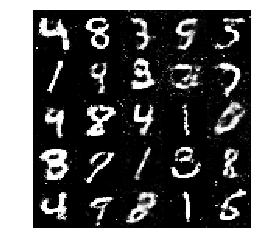

In [80]:
generate_images(generator)

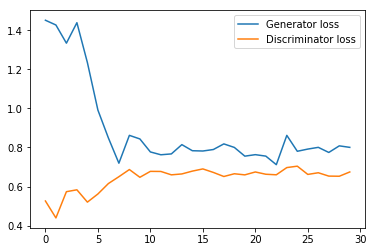

In [81]:
plt.plot(G_loss)
plt.plot(D_loss)
plt.legend(['Generator loss','Discriminator loss'])